In [98]:
import numpy as np
import pandas as pd
from sentence_transformers import util, SentenceTransformer

# Load data and embeddings
df = pd.read_csv("results/02_ai_scores.csv")
emb = np.load("results/01_embeddings.npy")

# Load SBERT model
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")


In [99]:
print(df.shape)
print(emb.shape)

(1200456, 10)
(1200456, 768)


clean the dataframe

In [100]:
def clean_df(df):
    """If dataframe has publisher/title columns, clean it."""
    if 'publisher' in df.columns:
        df = df[df['publisher'] != 'sn.dk'].copy()
    if 'publisher' in df.columns and 'title' in df.columns:
        df = df.drop_duplicates(subset=['publisher', 'title'])
    return df

In [102]:
# Clean all dfs that contain news-level rows
df = clean_df(df)
# set ai score threshold to 0.5
df = df[df['is_ai'] == True].copy()
df = df[df['ai_score'] >= 0.5].copy()
# Filter the primary yearly dataframe
df = df[df['published_date'] >= '2016'].copy()


This paper identifies barriers using an inductive thematic analysis on 196 peer-reviewed studies, following PRISMA screening, with two independent coders extracting and grouping all challenge-related statements into recurring themes such as resistance to change, skills gaps, and data-quality/privacy issues.<Adoption and integration of AI in organizations-a systematic review of challenges and drivers towards future directions of research>

In [103]:
barrier_queries = {
    "skills_gap":      "lack of AI skills, shortage of technical skills, insufficient expertise",
    "resistance":      "employee resistance, fear of automation, opposition to AI adoption",
    "privacy":         "data privacy, GDPR concerns, personal data protection issues",
    "data_quality":    "poor data quality, missing data, inconsistent datasets",
    "ethics_bias":     "algorithmic bias, fairness concerns, discrimination",
    "transparency":    "lack of model transparency, explainability issues, black-box AI"
}


In [104]:
emb = emb[df.index]

In [105]:
# Encode barrier queries
barrier_texts = list(barrier_queries.values())
barrier_emb = model.encode(barrier_texts, normalize_embeddings=True)

# Compute similarity
barrier_scores = util.cos_sim(emb, barrier_emb).cpu().numpy()

# Assign label with maximum similarity
df["barrier_type"] = [
    list(barrier_queries.keys())[i] for i in barrier_scores.argmax(axis=1)
]

df.to_csv("results/15_barrier_classification.csv", index=False)


search only from AI-related rows

In [106]:
ai_barriers = df[df["is_ai"]]["barrier_type"].value_counts()
ai_barriers.to_csv("results/16_barrier_distribution.csv")


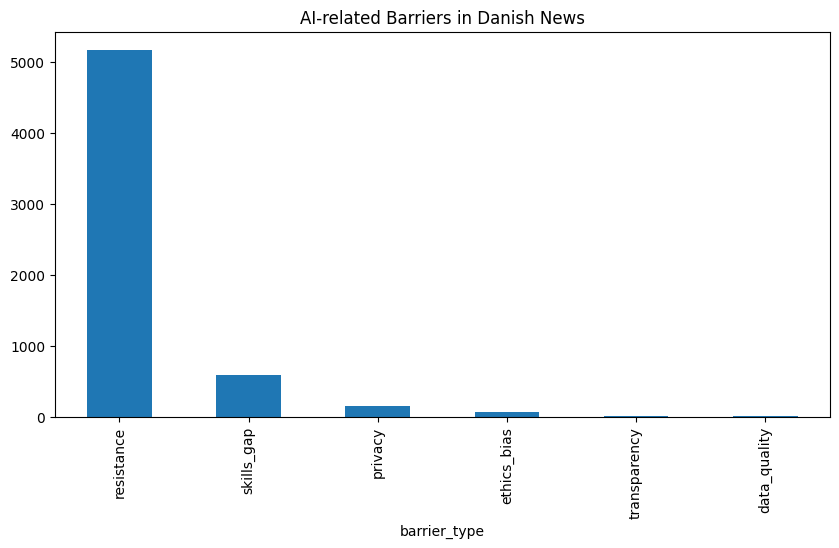

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ai_barriers.plot(kind="bar")
plt.title("AI-related Barriers in Danish News")
plt.show()

plt.savefig("figures/plot.png", bbox_inches="tight")
plt.close()


In [108]:
print(df.shape)
print(emb.shape)

(5973, 11)
(5973, 768)


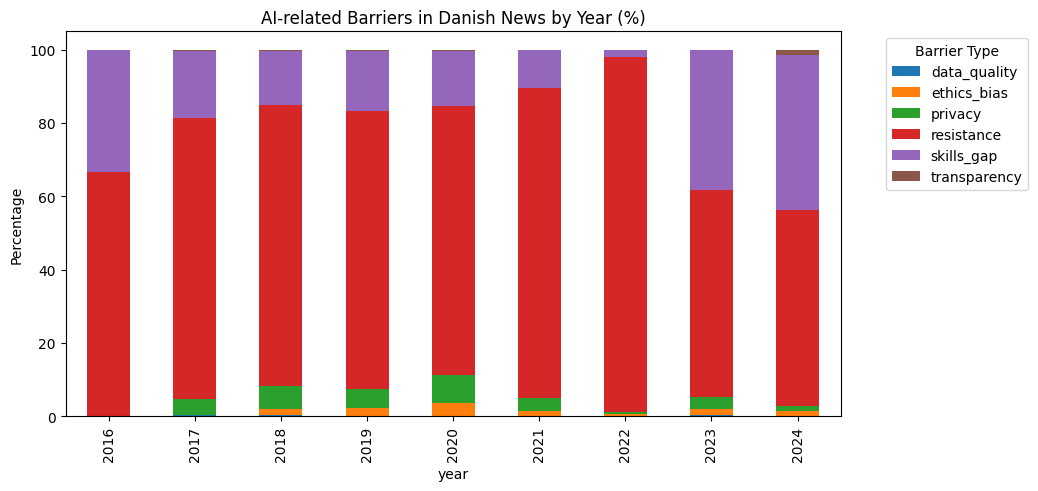

In [109]:
# AI-related Barriers in Danish News by Year in pct
df["year"] = pd.to_datetime(df["published_date"]).dt.year
barrier_year = df[df["is_ai"]].groupby(["year", "barrier_type"]).size().unstack(fill_value=0)
barrier_year_pct = barrier_year.div(barrier_year.sum(axis=1), axis=0) * 100
barrier_year_pct.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("AI-related Barriers in Danish News by Year (%)")
plt.ylabel("Percentage")
plt.legend(title="Barrier Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


trying using UMAP to detect clusters, explain barriers and events type

In [110]:
df

,plain_text,published_date,title,tags,categories,author,sitename,publisher,ai_score,is_ai,barrier_type,year
624,I onsdags blev et helt nyt aktivitetsområde me...,2016-12-23,Kunstgræsplæne indviet i Gadehavekvarteret,NaN,Foto galleri;Høje-Taastrup;Nyheder;Region Hove...,Rolf Larsen,Netavisen Sjælland,netavisen-sjaelland.dk,0.515836,True,skills_gap,2016
2373,Ny plads ved Den Frie GRØNT: Københavnerne ha...,2016-12-21,Ny plads ved Den Frie,NaN,nyheder,Navn,minby.dk,minby.dk,0.523777,True,resistance,2016
2497,Din internetbrowser er desværre uddateret. Den...,2016-12-29,10 grunde til at bruge intense farver i sovevæ...,soveværelse,Soveværelse,NaN,Bobedre.dk,bobedre.dk,0.501704,True,resistance,2016
2858,Du kan også logge ind via nedenstående tjenest...,2017-11-03,Morgen-briefing: Borgere i Rudersdal Kommune f...,NaN,NaN,Dan Jensen Twitter,Computerworld,computerworld.dk,0.504819,True,resistance,2017
3118,"Teknologi, digitalisering og automatisering få...",2017-10-31,Lokalt erhvervsliv fik et kig ind i fremtiden,NaN,NaN,Af Heiner Lützen Ank,Folkebladet,folkebladet.dk,0.507279,True,resistance,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
1199680,Da Thomas Visti fik tilbudt en af stolene i Lø...,2023-08-01,Fynsk hanløve 'spiste' en bid af to virksomhed...,NaN,Erhverv,Sophie Frederikke Gommesen Journalist,TV 2 Fyn,tv2fyn.dk,0.538210,True,resistance,2023
1199804,Chefredaktøren anbefaler: Grønland skal forber...,2024-01-27,Chefredaktøren anbefaler: Grønland skal forber...,Indland,NaN,Julia Aka Wille,Sermitsiaq.AG,sermitsiaq.ag,0.567721,True,resistance,2024
1200074,"Liselotte Kristiansen var lige kommet hjem, da...",2024-01-29,Liselotte fik et mystisk opkald: 'Det er uhygg...,Krimi,Nyheder,Sebastian Frølich,www.bt.dk,bt.dk,0.519946,True,resistance,2024
1200113,I et potentiel banebrydende tiltag forventes A...,2024-01-29,"AI-drevet Siri i iOS 18,",NaN,NaN,Maria,tweak.dk,tweak.dk,0.506621,True,skills_gap,2024


In [112]:
from umap import UMAP

# df filter only AI-related rows, apply UMAP on embeddings

print(df.shape)
print(emb.shape)
reduced = UMAP(n_neighbors=15, min_dist=0.0, metric="cosine").fit_transform(emb)


(5973, 12)
(5973, 768)


In [114]:
# mkdir results_cluster
import os
os.makedirs("results_cluster", exist_ok=True)
np.save("results_cluster/01_umap_reduced.npy", reduced)


In [115]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=40, metric='euclidean')
labels = clusterer.fit_predict(reduced)


E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [50]:
df

,plain_text,published_date,title,tags,categories,author,sitename,publisher,ai_score,is_ai,barrier_type,year,cluster
0,"Ung i krise Frihed, styrke og uendelig appeti...",2016-10-21,Sara blev psykisk syg som ung: Nu havde jeg ik...,"Skizofreni, psykisk sygdom, psykiske lidelser",Liv & Sjæl,Ung i krise Af Thilde Thordahl Andersen,Kristeligt Dagblad,kristeligt-dagblad.dk,0.376047,True,data_quality,2016,-1
1,Hvis livslængden øges i samme tempo i yderlige...,2016-10-20,Det meget lange liv er både fascinerende og sk...,"alder, aldring, Tid, udvikling, sundhed",Liv & Sjæl,Boguddrag Kaare Christensen; Professor Og Aldr...,Kristeligt Dagblad,kristeligt-dagblad.dk,0.383773,True,resistance,2016,622
2,Læs også Hvorfor skifter bladene farve? Hvorn...,2016-10-20,Test din viden om efteråret,"efterår, Quiz, blade, trækfugl",Quiz,Efterårsquiz Af Rasmus Fahrendorff,Kristeligt Dagblad,kristeligt-dagblad.dk,0.326066,True,resistance,2016,-1
3,Vores rådgivere får flere og flere henvendelse...,2016-10-18,Mødrehjælpen: Kontanthjælpsloft gør udsatte bo...,"hjælpeorganisation, mødrehjælpen, Politik, Dan...",Samfund,Af Rasmus Fahrendorff,Kristeligt Dagblad,kristeligt-dagblad.dk,0.384921,True,resistance,2016,-1
4,Skuespillere skal sammen med 80 statister skab...,2016-10-26,Vikingespil om nordisk kampiver på taget af Mo...,"Moesgaard Museum, Harald Blåtand",Kultur,Af Dorte Washuus,Kristeligt Dagblad,kristeligt-dagblad.dk,0.367990,True,privacy,2016,415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492054,"Det, der skulle have været en hyggelig ferie, ...",2024-01-31,Carol blev dræbt for 44 år siden: Nu er den br...,Udland,Nyheder,Maria Christine Madsen,www.bt.dk,bt.dk,0.327938,True,resistance,2024,219
492055,Amagermuseet tyvstarter Normalt holder byens ...,2024-01-31,Amagermuseet tyvstarter - Dragør Nyt,NaN,NaN,Admin,Dragør Nyt,dragoer-nyt.dk,0.375601,True,resistance,2024,-1
492056,Hvalpedåb på søbadet Fem nye vinterbader-hval...,2024-01-31,Hvalpedåb på søbadet - Dragør Nyt,NaN,NaN,Admin,Dragør Nyt,dragoer-nyt.dk,0.341686,True,skills_gap,2024,-1
492057,Nu skal der mere liv i det gamle værft Kommun...,2024-01-31,Nu skal der mere liv i det gamle værft - Dragø...,NaN,NaN,Admin,Dragør Nyt,dragoer-nyt.dk,0.464745,True,resistance,2024,-1


In [117]:
import joblib
from tqdm.auto import tqdm
df["cluster"] = labels
df.reset_index(drop=True, inplace=True)
df.to_csv("results_cluster/02_cluster_labels.csv", index=False)
print("✔ Saved cluster labels to results_cluster/02_cluster_labels.csv")

joblib.dump(clusterer, "results_cluster/clusterer.pkl")
print("✔ Saved HDBSCAN model")


# ============ 3) Compute Cluster Centroids ============

print("Computing cluster centroids…")

unique_clusters = sorted([c for c in set(labels) if c != -1])
centroids = {}

for cid in tqdm(unique_clusters, desc="Centroids"):
    idx = np.where(labels == cid)[0]
    vecs = emb[idx]
    centroid = vecs.mean(axis=0)
    centroid /= np.linalg.norm(centroid)
    centroids[cid] = centroid

np.save("results_cluster/03_cluster_centroids.npy", centroids)
print("✔ Saved centroids")


# ============ 4) Extract Representative Documents ============

print("Finding representative texts…")

representatives = {}

for cid in tqdm(unique_clusters, desc="Representatives"):
    idx = np.where(labels == cid)[0]
    vecs = emb[idx]
    centroid = centroids[cid]

    sims = vecs @ centroid
    top_k_idx = idx[np.argsort(-sims)[:5]]

    representatives[int(cid)] = df.loc[top_k_idx, "plain_text"].tolist()

# Save as JSON
import json
with open("results_cluster/04_representatives.json", "w", encoding="utf-8") as f:
    json.dump(representatives, f, ensure_ascii=False, indent=2)

print("✔ Saved representative texts")


# ============ 5) Auto-generate Cluster Label Sentences ============

print("Generating cluster summary sentences…")

summaries = {}
for cid in tqdm(unique_clusters, desc="Label Summary"):
    reps = representatives[int(cid)]   # ensure int index
    summaries[int(cid)] = reps[0] if len(reps) > 0 else ""

# Save JSON
import json
with open("results_cluster/05_cluster_label_sentences.json", "w", encoding="utf-8") as f:
    json.dump(summaries, f, ensure_ascii=False, indent=2)

print("✔ Saved cluster labeling sentences")


# ============ 6) Export Full Summary Table ============

summary_rows = []
for cid in unique_clusters:
    summary_rows.append({
        "cluster_id": cid,
        "size": (df["cluster"] == cid).sum(),
        "label_sentence": summaries[cid],
        "representatives": representatives[cid]
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("results_cluster/06_cluster_summary_table.csv", index=False)

print("✔ Full summary saved to 06_cluster_summary_table.csv")
print("🎉 All steps completed!")


✔ Saved cluster labels to results_cluster/02_cluster_labels.csv
✔ Saved HDBSCAN model
Computing cluster centroids…


Centroids: 100%|██████████| 11/11 [00:00<00:00, 2184.74it/s]


✔ Saved centroids
Finding representative texts…


Representatives: 100%|██████████| 11/11 [00:00<00:00, 1230.30it/s]


✔ Saved representative texts
Generating cluster summary sentences…


Label Summary: 100%|██████████| 11/11 [00:00<?, ?it/s]

✔ Saved cluster labeling sentences
✔ Full summary saved to 06_cluster_summary_table.csv
🎉 All steps completed!


In [118]:
df.shape

(5973, 13)